In [4]:
!pip install transformers

In [5]:
import sys, os, shutil, random, math
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import sklearn
from datetime import datetime, timedelta
from sklearn.metrics import *
from sklearn.utils import class_weight
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

# Transformer model
from transformers import AutoModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Check ROCM (If the 6700 XT is detected and used)
print(tf.config.list_physical_devices('GPU'))

# Increase the Pandas's output cell size
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 700)
pd.set_option('display.width', 1000)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Google Drive base path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Szakdoga'

In [9]:
# Load a csv file
filename = f'{BASE_PATH}/data/old/SlowALL1028.csv'
#filename = 'data/train/FalseALL0503.csv'
df = pd.read_csv(filename, skiprows=0)

# Get the timestamp
timestamp = df.iloc[0, 1]
print("Timestamp is:", timestamp)

# Skipping 2 rows
df = pd.read_csv(filename, skiprows=2)
df.head()

Timestamp is: 11084432530404


,X_ACC,Y_ACC,Z_ACC,X_GYRO,Y_GYRO,Z_GYRO,X_GRAVITY,Y_GRAVITY,Z_GRAVITY,X_MF,Y_MF,Z_MF,X_GMRV,Y_GMRV,Z_GMRV,TIME,LABEL
0,0.000000,0.000000,0.000000,-0.060718,-0.124100,-0.072569,-1.485139,-9.625180,1.149191,16.425001,30.900002,-23.625000,0.059273,0.661736,-0.745872,09:20,Slow
1,0.361434,-0.069506,-0.183116,-0.050332,0.279357,-0.184951,-0.813987,-9.740896,0.789142,15.975000,31.350000,-23.325000,0.061875,0.671938,-0.737999,-,Slow
2,-0.498501,0.106033,-0.042135,-0.166842,-0.027163,-0.154991,-0.761580,-9.767053,0.441673,15.825001,31.950000,-22.800001,0.060068,0.678037,-0.732405,-,Slow
3,-0.294392,0.135044,-0.124209,0.378557,0.000266,0.109186,-1.081274,-9.678743,1.150286,15.675000,32.250000,-22.500000,0.058626,0.675214,-0.734926,-,Slow
4,-0.121321,-2.650278,-1.438031,2.396508,-1.170425,1.418624,-2.670674,-7.778295,5.341912,15.600000,30.975000,-23.550001,0.042716,0.603473,-0.787595,09:21,Slow


In [10]:
def ConvertHourMinToHourMinSec(time_col):
    """Calculate timespan to seconds accuracy"""
    if len(str.split(time_col[0], ':')) == 2:
        # Get the initial time (h:m format)
        extended_time = time_col[0]

        # Calculating the steps until the next minute starts
        steps_to_next_min : int = 1
        r = time_col[1]
        while (r == '-'):
            steps_to_next_min += 1
            r = time_col[steps_to_next_min]

        # Adding the calculated seconds to the initial time (h:m:s)
        seconds = int(60 - np.round(steps_to_next_min / (300 / 60), 0))
        extended_time += f":{seconds}"
        return extended_time
    return time_col[0]

def ConvertOldDataToNewFormat(df, path : str, save_to_csv = False):
    # Defining the return dataframe
    df_to_return = df.copy(deep=True)
    # Get the first time with seconds accuracy and convert it to datetime format
    extended_time = ConvertHourMinToHourMinSec(df['TIME'])
    extended_time = datetime.strptime(extended_time, "%H:%M:%S") # Don't be fooled this variable contains the year, month, days too

    # The r_counter will take care of the sample gathering bc usually for every second we have 5 rows of data
    # Since we automatically increase the time with one sec, then we have to lower the initial value by 1
    r_counter = 1
    extended_time -= timedelta(seconds=1)

    # Inserting the new time formats
    for i, r in df_to_return.iterrows():
        if r_counter == 5 or r['TIME'] != '-':
            extended_time += timedelta(seconds=1)
            df_to_return.at[i, 'TIME'] = extended_time.strftime("%H:%M:%S")
            r_counter = 1
        else:
            df_to_return.at[i, 'TIME'] = extended_time.strftime("%H:%M:%S")
            r_counter += 1

    if (save_to_csv):
        df.to_csv(path, index=False)
    else:
        return df_to_return

def GroupSamplesBySeconds(df: pd.DataFrame, mode="mean"):
    df_result = pd.DataFrame()
    print("OLD LENGTH:", len(df.index))

    if '-' in df['TIME'].values:
        df = ConvertOldDataToNewFormat(df, 'XD')

    if mode == "first":
        df_result = df_result.groupby('TIME').first()
    else:
        first_i = 0
        for i, r in df.iterrows():
            if r['TIME'] != df.iloc[i - 1]['TIME'] and i != 0:
                # Adds a new row with averaged values
                row = pd.DataFrame([{'X_ACC' : df.iloc[first_i : i]['X_ACC'].mean(), 'Y_ACC' : df.iloc[first_i : i]['Y_ACC'].mean(), 'Z_ACC' : df.iloc[first_i : i]['Z_ACC'].mean(),
                    'X_GYRO' : df.iloc[first_i : i]['X_GYRO'].mean(), 'Y_GYRO' : df.iloc[first_i : i]['Y_GYRO'].mean(), 'Z_GYRO' : df.iloc[first_i : i]['Z_GYRO'].mean(),
                    'X_GRAVITY' : df.iloc[first_i : i]['X_GRAVITY'].mean(), 'Y_GRAVITY' : df.iloc[first_i : i]['Y_GRAVITY'].mean(), 'Z_GRAVITY' : df.iloc[first_i : i]['Z_GRAVITY'].mean(),
                    'X_GMRV' : df.iloc[first_i : i]['X_GMRV'].mean(), 'Y_GMRV' : df.iloc[first_i : i]['Y_GMRV'].mean(), 'Z_GMRV' : df.iloc[first_i : i]['Z_GMRV'].mean(),
                    'TIME' : df.iloc[first_i]['TIME'], 'LABEL' : df.iloc[first_i]['LABEL']}])
                df_result = pd.concat([df_result, row])
            # Refreshes the index to show the location of the first occurence with the new time
            first_i = i

    print("NEW LENGTH:", len(df_result.index))
    return df_result

In [11]:
# Numerize label name
def NumerizeLabelNames(label: str):
  if label == 'Slow':
    return 0
  elif label == 'Normal':
    return 1
  else:
    return 2

# Create a dataset without the Magnetic Field column
def MagneticFieldFuckery(df: pd.DataFrame):
    df_result = pd.DataFrame()

    for i, r in df.iterrows():
        row = pd.DataFrame([{'X_ACC' : r['X_ACC'], 'Y_ACC' : r['Y_ACC'], 'Z_ACC' : r['Z_ACC'],
                    'X_GYRO' : r['X_GYRO'], 'Y_GYRO' : r['Y_GYRO'], 'Z_GYRO' : r['Z_GYRO'],
                    'X_GRAVITY' : r['X_GRAVITY'], 'Y_GRAVITY' : r['Y_GRAVITY'], 'Z_GRAVITY' : r['Z_GRAVITY'],
                    'X_GMRV' : r['X_GMRV'], 'Y_GMRV' : r['Y_GMRV'], 'Z_GMRV' : r['Z_GMRV'],
                    'LABEL' : r['LABEL']}])
        df_result = pd.concat([df_result, row])

    return df_result

# Balance the dataset
def BalanceDataset(df: pd.DataFrame):
  # Turning data into numpy arrays
  input_data = df[df.columns[0:len(df.columns) - 2]].values
  target = df['LABEL'].values

  # SMOTE
  # # Oversampling the data
  # smote = SMOTE(random_state = 101)
  # X, y = smote.fit_resample(input_data, target)

  # ADASYN
  # # Oversampling the data
  # smote = SMOTE(random_state = 101)
  # X, y = smote.fit_resample(input_data, target)

  # RANDOM OVERSAMPLING
  unique, counts = np.unique(target, return_counts=True)
  class_counts = dict(zip(unique, counts))
  ros = RandomOverSampler(random_state=69, sampling_strategy={"Slow": class_counts["Slow"],
                                                              "Normal": class_counts["Normal"],
                                                              "Fast": class_counts["Fast"] * 3})
  X, y = ros.fit_resample(input_data, target)

  # UNDERSAMPLING
  cc = ClusterCentroids(random_state=60)
  X, y = cc.fit_resample(X, y)

  for (i, feature) in enumerate(y):
      y[i] = NumerizeLabelNames(y[i])

  # Create a new Dataframe
  df_X = pd.DataFrame(X, columns=df.columns[0:len(df.columns) - 2])
  df_y = pd.DataFrame(y, columns=['LABEL'])
  df_result = pd.concat([df_X, df_y], axis=1)

  print("-----AFTER BALANCING-----")
  print("Slow:",np.count_nonzero(y == 0))
  print("Normal:",np.count_nonzero(y == 1))
  print("Fast:",np.count_nonzero(y == 2))

  return df_result

In [12]:
# Turning data into numpy arrays
input_data = df[df.columns[0:len(df.columns) - 2]].values
target = df['LABEL'].values

T = 60
D = input_data.shape[1] - 3
N = len(input_data) - T

In [13]:
# TRANSFORMER MODEL
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_model(
    (T, D),
    n_classes=3,
    head_size=256,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=8,
    mlp_units=[128],
    mlp_dropout=0.3,
    dropout=0.3,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.000001),
    metrics=["sparse_categorical_accuracy"],
)

In [14]:
# Building model
K = 3
i = layers.Input(shape=(T, D))
x = layers.LSTM(32, return_sequences=True, dropout=0.3,
                kernel_regularizer=regularizers.l2(0.001)
                )(i)
x = layers.LSTM(32, return_sequences=True, dropout=0.3,
                kernel_regularizer=regularizers.l2(0.001)
                )(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(K, activation='softmax')(x)

model = keras.Model(i, x)

model.compile(optimizer=optimizers.Adam(learning_rate=0.000001), # learning_rate=0.000001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Convert the old datas to new format and save to csv
# ConvertOldDataToNewFormat(pd.read_csv('data/old/NormalALL1018.csv', skiprows=2), path='data/NormalALL1018.csv', save_to_csv=True)
# ConvertOldDataToNewFormat(pd.read_csv('data/old/SlowALL1025 (1).csv', skiprows=2), path='data/SlowALL1025 (1).csv', save_to_csv=True)
# ConvertOldDataToNewFormat(pd.read_csv('data/old/SlowALL1028.csv', skiprows=2), path='data/SlowALL1028.csv', save_to_csv=True)

In [15]:
def DoWindowing(y: np.array):
    # Splitting to 60 sized batches
    Y_result = np.copy(y)
    for window_amount in range(math.ceil(len(y) / T)):
        if T*window_amount < len(y):
            # Calculating class frequency (how often do they appear)
            class_frequencies = { 0: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 0), 1: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 1), 2: np.count_nonzero(y[T*window_amount:T*(window_amount+1)] == 2) }
            highest_frequency_class = sorted(class_frequencies.items(), key=lambda item:item[1], reverse=True)[0][0]
            # Assigning the highest frequency class to the batch labels
            i = T*window_amount
            for label in y[T*window_amount:T*(window_amount+1)]:
                Y_result[i] = highest_frequency_class
                i += 1
            # print(Y_result[T*window_amount:T*(window_amount+1)])
        else:
            # Calculating class frequency (how often do they appear)
            class_frequencies = { 0: np.count_nonzero(y[(T*window_amount):] == 0), 1: np.count_nonzero(y[(T*window_amount):] == 1), 2: np.count_nonzero(y[(T*window_amount):] == 2) }
            highest_frequency_class = sorted(class_frequencies.items(), key=lambda item:item[1], reverse=True)[0][0]
            # Assigning the highest frequency class to the batch labels
            for i, label in enumerate(y[T*window_amount:]):
                Y_result[i] = highest_frequency_class
            # print(Y_result[T*window_amount:])
    return Y_result

In [16]:
def CheckClassRatios():
    for i in glob(f'{BASE_PATH}/data/train/*.csv'):
        print(i)
        df_initial = pd.read_csv(i, skiprows=0)
        if 'TIME' not in df_initial.columns.to_list():
            df_initial = pd.read_csv(i, skiprows=2)
        target = df_initial['LABEL'].values
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(target),
                                                 y=target)
        print(class_weights)

    for j in glob(f'{BASE_PATH}/data/test/*.csv'):
        print(j)
        df_initial = pd.read_csv(j, skiprows=0)
        if 'TIME' not in df_initial.columns.to_list():
            df_initial = pd.read_csv(j, skiprows=2)
        target = df_initial['LABEL'].values
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(target),
                                                 y=target)
        print(class_weights)

    for k in glob(f'{BASE_PATH}/data/others/*.csv'):
        print(k)
        df_initial = pd.read_csv(k, skiprows=0)
        if 'TIME' not in df_initial.columns.to_list():
            df_initial = pd.read_csv(k, skiprows=2)
        target = df_initial['LABEL'].values
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(target),
                                                 y=target)
        print(class_weights)

def CheckClassFeatureStats():
    for i in glob(f'{BASE_PATH}/data/train/*.csv'):
        # Reading the file and skipping the first 2 rows
        df = pd.read_csv(i, skiprows=0)
        if 'TIME' not in df.columns.to_list():
            df = pd.read_csv(i, skiprows=2)
        # Selecting those rows which are labelled as 'Slow'
        print("-------------SLOW STATS-------------")
        df_slow = df.loc[df['LABEL'] == 'Slow']
        print(df_slow.describe())
        # Selecting those rows which are labelled as 'Normal'
        print("-------------NORMAL STATS-------------")
        df_normal = df.loc[df['LABEL'] == 'Normal']
        print(df_normal.describe())
        # Selecting those rows which are labelled as 'Fast'
        print("-------------FAST STATS-------------")
        df_fast = df.loc[df['LABEL'] == 'Fast']
        print(df_fast.describe())

import matplotlib.pyplot as plt
import pandas as pd

def PlotFeatureStats(path: str):
    # Reading the file and skipping the first 2 rows
    df = pd.read_csv(path, skiprows=0)
    if 'TIME' not in df.columns.to_list():
        df = pd.read_csv(path, skiprows=2)
    # Selecting those rows which are labelled as 'Slow'
    df_slow = df.loc[df['LABEL'] == 'Slow']
    # Selecting those rows which are labelled as 'Normal'
    df_normal = df.loc[df['LABEL'] == 'Normal']
    # Selecting those rows which are labelled as 'Fast'
    df_fast = df.loc[df['LABEL'] == 'Fast']
    # Plot column stats
    columns = df.columns[0:len(df.columns) - 2]
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # Round up to the nearest multiple of 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows*4))
    axes = axes.flatten()  # Convert axes to a 1D array

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.plot(df_slow[col], label='Slow')
        ax.plot(df_normal[col], label='Normal')
        ax.plot(df_fast[col], label='Fast')
        ax.legend()
        ax.set_title(col)

    # Remove empty subplots
    if num_plots < len(axes):
        for j in range(num_plots, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [17]:
def SaveModel():
    # Saving weights
    model.save_weights(f'./weights/model')

    # Saving model
    saved_model = tf.saved_model.save(model, f'/tmp/model')

    return saved_model

def SetupTests(test_path: str):
    # Reading the file and skipping the first 2 rows
    df_initial = pd.read_csv(test_path, skiprows=0)
    # Clean / format the data (1 sample per seconds)
    # df = GroupSamplesBySeconds(df_initial)
    # df.columns = ['X_ACC', 'Y_ACC', 'Z_ACC', 'X_GYRO', 'Y_GYRO', 'Z_GYRO', 'X_GRAVITY', 'Y_GRAVITY', 'Z_GRAVITY',
    #                       'X_MF', 'Y_MF', 'Z_MF', 'X_GMRV', 'Y_GMRV', 'Z_GMRV', 'TIME', 'LABEL']
    df = GroupSamplesBySeconds(df_initial)
    df = MagneticFieldFuckery(df)
    # Turning data into numpy arrays
    input_data = df[df.columns[0:len(df.columns) - 1]].values
    target = df['LABEL'].values

    # Check the old data length and the grouped one
    # print("Initial:", len(df_initial[df_initial.columns[0:len(df_initial.columns) - 2]].values), "Averaged:", len(input_data))

    T = 60
    D = input_data.shape[1]
    N = len(input_data) - T
    # Setup X_test and Y_test
    X_test = np.zeros((N, T, D))
    Y_test = np.zeros(N)

    for t in range(N ):
        X_test[t, :, :] = input_data[t:t+T]
        Y_test[t] = NumerizeLabelNames(target[t+T])

    Y_test = DoWindowing(Y_test)

    return X_test, Y_test


def PreprocessFilesAndTrain(train_paths: list(), test_path: str, model):
    # These variables will be returned back to where it was called
    r = None

    X_test, Y_test = SetupTests(test_path)

    for j in train_paths:
        # Reading the file and skipping the first 2 rows
        print(j)
        df_initial = pd.read_csv(j, skiprows=0)
        if 'TIME' not in df_initial.columns.to_list():
            df_initial = pd.read_csv(j, skiprows=2)
        # Clean / format the data (1 sample per seconds)
        # df = GroupSamplesBySeconds(df_initial)
        df = GroupSamplesBySeconds(df_initial)
        df = MagneticFieldFuckery(df)
        print(np.unique(df['LABEL'].values.astype(str)))
        # Turning data into numpy arrays
        input_data = df[df.columns[0:len(df.columns) - 1]].values
        target = df['LABEL'].values

        # Check the old data length and the grouped one
        # print("Initial:", len(df_initial[df_initial.columns[0:len(df_initial.columns) - 2]].values), "Averaged:", len(input_data))

        T = 60
        D = input_data.shape[1]
        N = len(input_data) - T
        # Normalize data
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(input_data)
        input_data = scaler.transform(input_data)


        # Setup X_train and Y_train
        X_train = np.zeros((N, T, D))
        Y_train = np.zeros(N)

        for t in range(N):
            X_train[t, :, :] = input_data[t:t+T]
            Y_train[t] = NumerizeLabelNames(target[t+T])

        Y_train = DoWindowing(Y_train)

        # Calculate class weights
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(Y_train),
                                                 y=Y_train)

        cw_dict = None
        if (len(np.unique(Y_train)) < 3):
            cw_dict = { 0: class_weights[0], 1: class_weights[1] }
        else:
            cw_dict = { 0: class_weights[0], 1: class_weights[1], 2: class_weights[2] }
        print(cw_dict)

        # Fitting stage
        r = model.fit(X_train, Y_train,
              batch_size=6,
              validation_data=(X_test, Y_test),
              epochs=500,
              class_weight=cw_dict,
              callbacks=keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True #it literally means wat u think (simpleeeeee)
            ))

    return r

In [ ]:
CheckClassRatios()

/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SlowALL0414_shifted(idk).csv
[4.39350181 0.60971944 0.88316401]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/NormalALL1018.csv
[2.64761905 0.5963106  1.05783866]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SlowALL1028.csv
[4.96678967 0.74944321 0.68290208]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SlowALL0331 (1).csv
[3.36947791 0.46543236 1.80284717]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SENSOR_DATA0511 (1).csv
[1.09455928 0.60602473 2.2920398 ]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/FalseALL0421 (1).csv
[1.73204716 0.63936696 1.16468468]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SENSOR_DATA0512.csv
[1.91018131 0.8584681  0.76241372]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/FalseALL0503.csv
[3.2828849  0.64786136 0.86816879]
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SlowALL1118.csv
[3.73411

In [ ]:
CheckClassFeatureStats()

-------------SLOW STATS-------------
             X_ACC        Y_ACC        Z_ACC       X_GYRO       Y_GYRO       Z_GYRO    X_GRAVITY    Y_GRAVITY    Z_GRAVITY       X_GMRV       Y_GMRV       Z_GMRV
count  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000  1241.000000
mean     -0.064601    -0.075899    -0.130164     0.002785    -0.005348     0.022543     1.264061    -7.159034     5.316001    -0.252758     0.246117    -0.518078
std       1.020290     1.417815     1.339617     0.891160     0.535252     0.314867     1.738021     2.491161     2.431506     0.157983     0.283117     0.557617
min      -7.243038    -8.907865    -9.489344    -6.072917    -3.167947    -1.642769    -2.617750    -9.804159    -2.962868    -0.599035    -0.656609    -0.965835
25%      -0.337692    -0.538245    -0.444239    -0.067501    -0.130725    -0.081245     0.147509    -9.099598     3.608209    -0.328547     0.168557    -

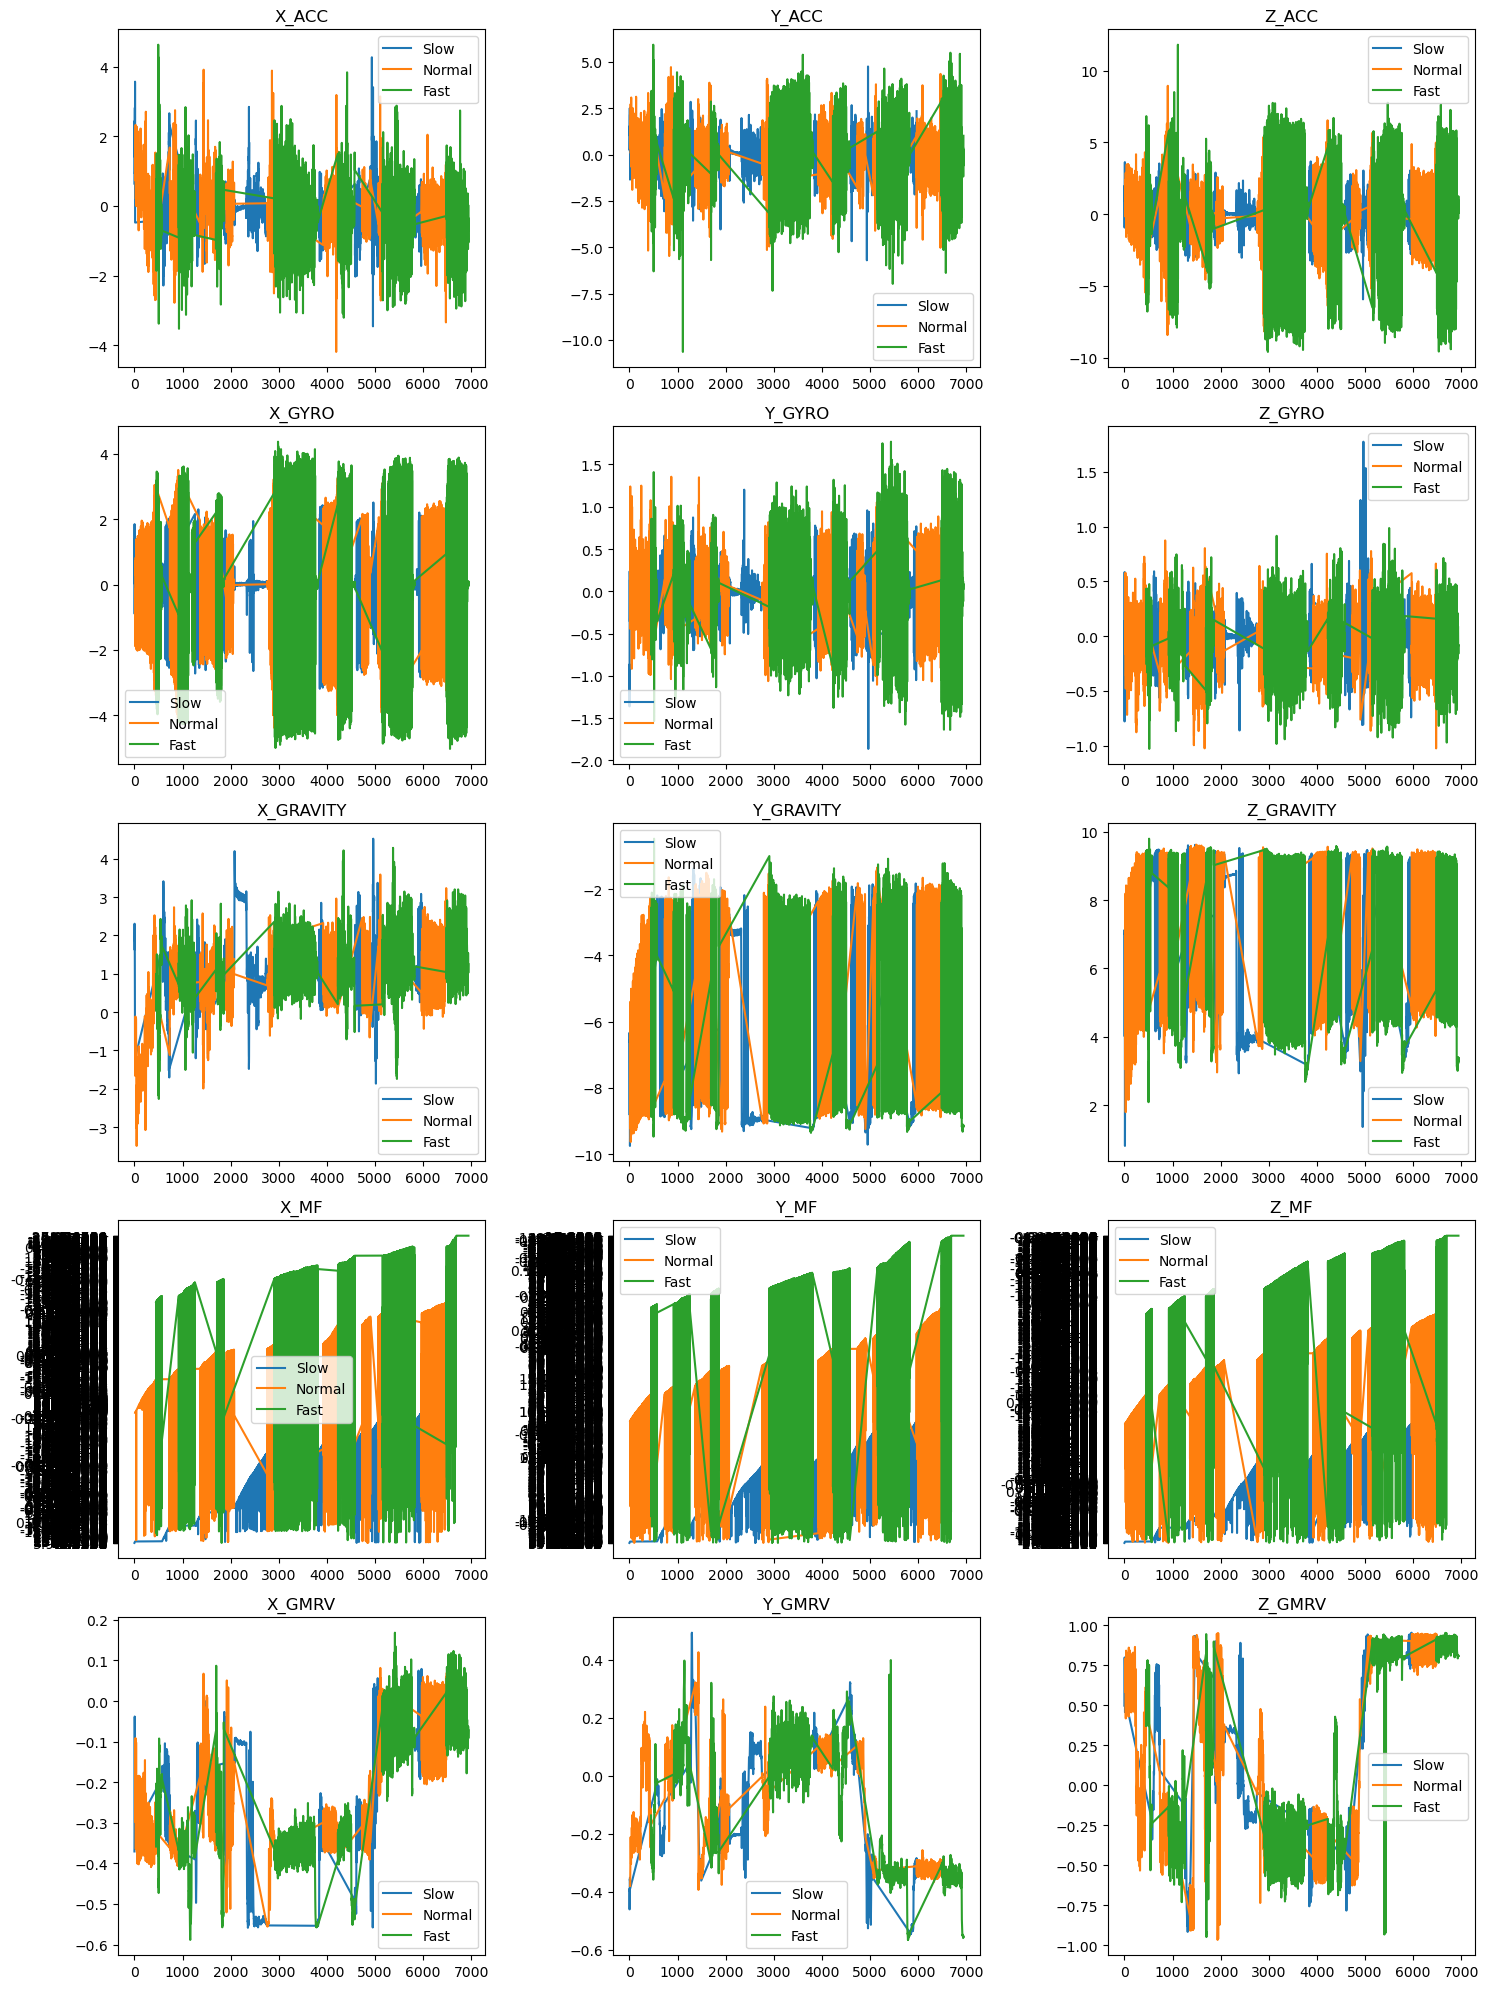

In [ ]:
# Plot each feature for 'Slow', 'Normal, 'Fast' for 1 dataset
PlotFeatureStats('data/train/SENSOR_DATA0517.csv')

In [18]:
model.load_weights(f'{BASE_PATH}/weights/model_2LSTM-3/model_2LSTM-3.h5')

In [20]:
# Fitting the modell to all the csv files
r = PreprocessFilesAndTrain(glob(f'{BASE_PATH}/data/train/*.csv'), f'{BASE_PATH}/data/test/SlowALL1025 (1).csv', model=model)

OLD LENGTH: 3652
NEW LENGTH: 739
/content/drive/MyDrive/Colab Notebooks/Szakdoga/data/train/SlowALL0414_shifted(idk).csv
OLD LENGTH: 3651
NEW LENGTH: 528
['Fast' 'Normal' 'Slow']
{0: 0.8666666666666667, 1: 0.6842105263157895, 2: 2.6}
Epoch 1/500
78/78 [==============================] - 12s 29ms/step - loss: 1.1423 - accuracy: 0.3739 - val_loss: 0.9691 - val_accuracy: 0.5670
Epoch 2/500
78/78 [==============================] - 1s 13ms/step - loss: 1.1436 - accuracy: 0.3526 - val_loss: 0.9692 - val_accuracy: 0.5670
Epoch 3/500
78/78 [==============================] - 1s 13ms/step - loss: 1.1561 - accuracy: 0.3526 - val_loss: 0.9695 - val_accuracy: 0.5685
Epoch 4/500
78/78 [==============================] - 1s 13ms/step - loss: 1.1279 - accuracy: 0.3846 - val_loss: 0.9697 - val_accuracy: 0.5685
Epoch 5/500
78/78 [==============================] - 1s 13ms/step - loss: 1.1486 - accuracy: 0.3419 - val_loss: 0.9699 - val_accuracy: 0.5685
Epoch 6/500
78/78 [==============================] - 1s

In [ ]:
# Saving weights
filename = 'model_2LSTM-3.2'

model.save_weights(f'./weights/{filename}/{filename}')

# Saving model
# saved_model = tf.saved_model.save(model, f'/tmp/model')
model.save(f"./weights/{filename}/{filename}.h5", save_format="h5")

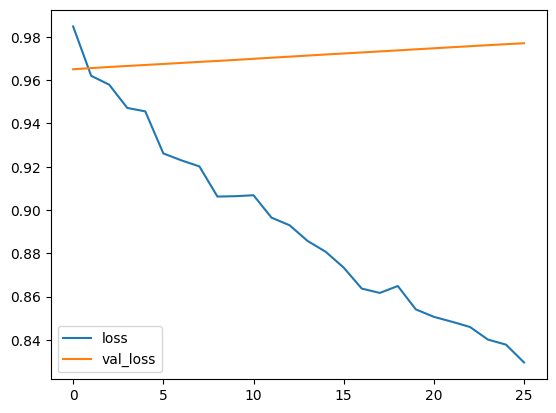

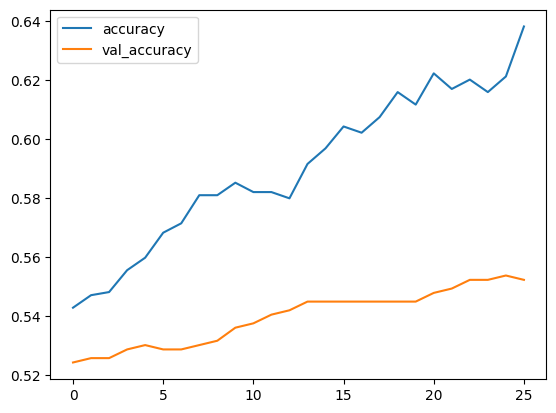

In [24]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Usual accuracy plotting
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Converting model to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(f'/tmp/model')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open(f'model.tflite', 'wb') as f:
  f.write(tflite_model)


OSError: ignored

In [25]:
X_test, Y_test = SetupTests(f'{BASE_PATH}/data/test/SlowALL1025 (1).csv')

# Predict
Y_pred = model.predict(X_test)

# Convert to classes
Y_pred_classes = list()
for row in Y_pred:
    max_idx = 0
    idx = 0

    for label in row[1:]:
        if label > row[max_idx]:
            max_idx = idx
        idx += 1

    Y_pred_classes.append(max_idx)

Y_pred_classes = np.array(Y_pred_classes)

OLD LENGTH: 3652
NEW LENGTH: 739
22/22 [==============================] - 1s 5ms/step


In [26]:
# Calculate AUC
roc_auc_score(Y_test, Y_pred, multi_class='ovr')

0.7367913872561097

In [27]:
# F1 score
f1_score(Y_test, Y_pred_classes, average='weighted')

0.5207472724297277

In [28]:
# Help for imbalanced datasets https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def PlotConfusionMatrix():
    # Plotting confusion matrix
    cf_matrix = sklearn.metrics.confusion_matrix(Y_test, Y_pred_classes, normalize='all')
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    # Adding title names
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Adding label names to each category
    ax.xaxis.set_ticklabels(["Slow", "Normal", "Fast"])
    ax.yaxis.set_ticklabels(["Slow", "Normal", "Fast"])

    plt.show()

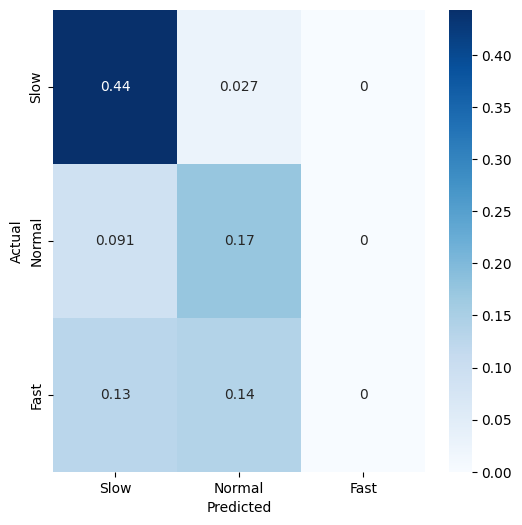

In [29]:
# Plot confusion matrix with the DEFAULT threshold value
PlotConfusionMatrix()

In [30]:
# Defining the ROC (TP vs FP curve) and AUPRC (Precision-Recall curve) functions
def PlotROC(labels, preds):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, preds)
    # Calculate the g-mean for each threshold
    gmeans = np.sqrt(tp * (1-fp))
    # Locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print(f"Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}")
    # Plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fp, tp, marker='.', label='CNN')
    plt.scatter(fp[ix], tp[ix], marker='o', color='green', label='Best')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return thresholds[ix]

def PlotPRC(labels, preds):
    # Calculate pr-curve
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, preds)
    # Calculating the best f-score
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f"Best threshold: {thresholds[ix]}, Best F-score: {fscore[ix]}")
    # Plot the ROC curve
    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='CNN')
    plt.scatter(recall[ix], precision[ix], marker='o', color='green', label='Best')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return thresholds[ix]


In [31]:
# Get only the positive tests probs
Y_pred_pos_probs = list()
for prob in Y_pred:
    Y_pred_pos_probs.append(prob[1])
len(Y_pred_pos_probs)

679

Best Threshold=0.26816338300704956, G-Mean=0.9088758512332014


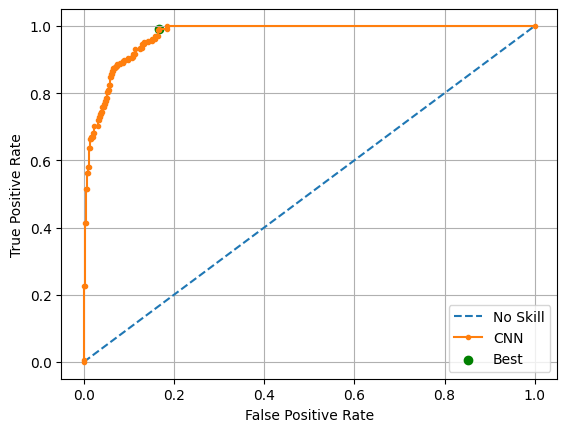

Best threshold: 0.30556759238243103, Best F-score: 0.8733624454148472


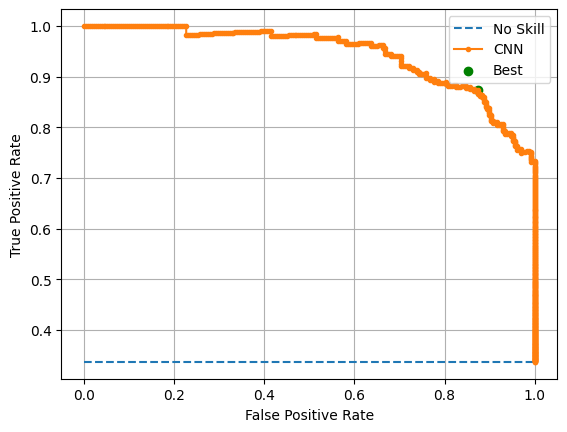

In [32]:
# Plotting optimal threshold of ROC Curve
best_roc_threshold = PlotROC(Y_pred_classes, Y_pred_pos_probs)
# Plotting optimmal threshold of PRC. Looks pretty awful ngl (PRC only cares about the minority class)
best_prc_threshold = PlotPRC(Y_pred_classes, Y_pred_pos_probs)